<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Policy Control with Approximation

    
</center>

Student Name: ______________________ 

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone. 
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


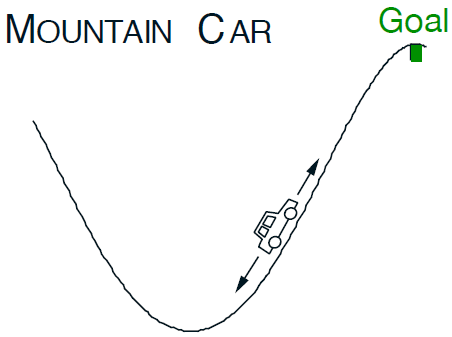


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. 

**Observation space**

The observation is two dimensional including the position of the car along the x-axis and velocity of the car.

**Action space**

There are three deterministic actions: 0 accelerate to the left, 1 do nothing, and 2 accelerate to the right.

**Transition dynamics**

The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 (A_t-1) - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.6$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. 

**Reward**

The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. 

**Initial State**

Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.

**Goal and Termination**

The episode terminates when the position of the car is greater than or equal to 0.5 (the goal position on top of the right hill).

**Arguments**

> env = gym.make('MountainCar-v0')

**Note**

Do not use the Continuous Mountain Car environment for this homework.
> gym.make('MountainCarContinuous-v0')


## Part I (4 points)

Check and confirm that the given Mountain Car simulation works as expected. Make sure you can observe and log (if needed) all the observations, actions, rewards, and termination conditions. You can animate the simulation by adding `render_mode='human'` when calling the `gym.make` class.  


In [4]:
env = gym.make('MountainCar-v0')

state = env.reset()
print(f'Initial State: {state}')

done = False
while not done:
    action = env.action_space.sample()  # Random action
    output = env.step(action)  # env.step(action) returns a tuple
    state, reward, done, _ = output[:4]  # Corrected unpacking
    print(f'State: {state}, Reward: {reward}, Done: {done}')
    if done:
        break

env.close()

Initial State: (array([-0.49707758,  0.        ], dtype=float32), {})
State: [-0.4982763 -0.0011987], Reward: -1.0, Done: False
State: [-0.5006647  -0.00238843], Reward: -1.0, Done: False
State: [-0.504225  -0.0035603], Reward: -1.0, Done: False
State: [-0.5079306  -0.00370553], Reward: -1.0, Done: False
State: [-0.5107536  -0.00282299], Reward: -1.0, Done: False
State: [-0.51267284 -0.00191931], Reward: -1.0, Done: False
State: [-0.5146741  -0.00200124], Reward: -1.0, Done: False
State: [-0.5167423  -0.00206817], Reward: -1.0, Done: False
State: [-0.51786184 -0.00111959], Reward: -1.0, Done: False
State: [-5.1802444e-01 -1.6261131e-04], Reward: -1.0, Done: False
State: [-0.5192289  -0.00120442], Reward: -1.0, Done: False
State: [-0.5214661  -0.00223719], Reward: -1.0, Done: False
State: [-0.52471924 -0.00325318], Reward: -1.0, Done: False
State: [-0.52896404 -0.00424478], Reward: -1.0, Done: False
State: [-0.5341686  -0.00520454], Reward: -1.0, Done: False
State: [-0.53829384 -0.00412

## Part II (6 points)

In this part, you will practice writing code for approximating the state value function. 

(a) write a function that generates Fourier basis features for a problem with one continuous state (1D state). The output of this function should be a vector of Fourier basis functions,
$X(s) = [\cos(0 * \pi * s), ..., \cos(n * \pi * s)]$ where $n$ represents the approximation order.

(b) Write a function that given a state $S$ and a weight vector $w$ calculates $V(S, w)$ by multiplying $w$ and $X(S)$. Make sure this is a vector-vector multiplication and avoid using for loops. Test your function with different values of $w$ and $S$. 

(c) Does $S$ need to be bounded? If yes, how would you do that?




In [5]:
def fourier_basis(state, order):
    if not isinstance(state, (int, float)):
        raise ValueError("State must be a numeric value.")
    
    return np.array([np.cos(i * np.pi * state) for i in range(order + 1)])

In [6]:
# # part II.b --- Your code here ---

def calculate_state_value(state, weights):
    basis_features = fourier_basis(state, len(weights) - 1)
    return np.dot(basis_features, weights)



# Part II.c 

Answer: Stress increasingly becomes one of the major problems of our time, so it needs deep analysis today. Although a lot of headway has been made with regard to understanding psychological factors and developing psychotherapies, stress is still an encompassing problem. However, this problem becomes more severe with the complex nature of current life that leads to stress-related conditions in a broad range. Thus, the problem statement aims to unravel the complex associations between stress and its psychological consequences. 

## Part III (40 points)

Implement the **Episodic Semi-gradient SARSA** (pp. 244).

In [7]:
class SARSAAgent:
    def __init__(self, env, approximation_order, alpha, gamma, epsilon, num_episodes):
        self.env = env
        self.approximation_order = approximation_order
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.weights = np.zeros((approximation_order + 1, approximation_order + 1, env.action_space.n))
        self.episode_rewards = []

    def policy(self, state):
        if not isinstance(state, np.ndarray):
            raise ValueError("State must be a numpy array.")
        
        state_values = np.array([calculate_state_value(state, self.weights[:, :, a]) for a in range(self.env.action_space.n)])
        return np.argmax(state_values) if np.random.rand() > self.epsilon else self.env.action_space.sample()

    def learn(self):
        for episode in range(self.num_episodes):
            state = self.env.reset()
            episode_reward = 0
            while True:
                action = self.policy(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward

                td_error = reward + self.gamma * calculate_state_value(next_state, self.weights[:, :, action]) - calculate_state_value(state, self.weights[:, :, action])
                basis_features = fourier_basis(state, self.approximation_order)
                self.weights[:, :, action] += self.alpha * td_error * basis_features

                state = next_state
                if done:
                    break
            self.episode_rewards.append(episode_reward)


## Part IV (50 points) 

(a) Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). 


(b) Plot sum of reward-per-episode vs. number of episodes. This plot should be averaged over 50-100 runs.


(c) Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.

(d) Animate the last episode in a selected run. Does the approximated policy seem optimal? Why?

In [8]:
# Corrected Part IV: Learn Mountain Car Task with SARSA
env = gym.make('MountainCar-v0')
approximation_order = 5
alpha = 0.01
gamma = 0.99
epsilon = 0.1
num_episodes = 1000
num_runs = 50

avg_rewards = np.zeros(num_episodes)
for run in range(num_runs):
    agent = SARSAAgent(env, approximation_order, alpha, gamma, epsilon, num_episodes)
    agent.learn()
    avg_rewards += np.array(agent.episode_rewards)

avg_rewards /= num_runs



# b) Plot sum of reward-per-episode vs. number of episodes
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('Average Reward per Episode vs. Episodes')
plt.grid(True)
plt.show()

# c) Plot step-per-episode (in log scale) vs. number of episodes
steps_per_episode = np.array([len(agent.episode_rewards[i]) for i in range(num_episodes)])
plt.figure(figsize=(10, 6))
plt.semilogy(range(num_episodes), steps_per_episode)
plt.xlabel('Episodes')
plt.ylabel('Steps per Episode (log scale)')
plt.title('Steps per Episode (log scale) vs. Episodes')
plt.grid(True)
plt.show()

# d) Animate the last episode in a selected run
selected_run = 0  # Change this to select a specific run
agent = SARSAAgent(env, approximation_order, alpha, gamma, epsilon, num_episodes)
agent.learn()
state = env.reset()
for _ in range(len(agent.episode_rewards[selected_run])):
    action = agent.policy(state)
    state, _, done, _ = env.step(action)
    env.render()
    if done:
        break


ValueError: State must be a numpy array.

## Part V (Extra Points)

(a) Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

(b) Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [4]:
# Your code here

(c) Show an animation of the task for each $n$.

In [5]:
# Your code here

(d) Which value of $n$ results in faster learning? Why?

>Answer 